In [ ]:
# !pip install graphviz
# !pip install torch
# !pip install tensorflow
# !pip install matplotlib

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot


In [6]:
from __future__ import annotations
import math
import random

class Value:
    def __init__(self, value, children=(), op = ""):
        self.data = value
        self.children = set(children)
        self.label = ""
        self.op = op
        self.grad = 0.0
        self.backward = lambda: None

    def __str__(self) -> str:
        return f"Value({self.data})"

    def __repr__(self) -> str:
        return f"Value({self.data})"

    def __add__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        output = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * output.grad
            other.grad += 1.0 * output.grad

        output.backward = _backward
        return output

    def __radd__(self, other) -> Value:
        return self.__add__(other)

    def __mul__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        output = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += output.grad * other.data
            other.grad += output.grad * self.data

        output.backward = _backward
        return output
    
    def __rmul__(self, other) -> Value:
        return self.__mul__(other)

    def __pow__(self, other):
        other = other if isinstance(other, (int, float)) else other.data

        output = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * output.grad
    
        output.backward = _backward
        return output
    
    def __rpow__(self, other) -> Value:
        return self.__pow__(other)

    def __truediv__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        return self * (other ** -1)

    def __rtruediv__(self, other) -> Value:
        other = Value(other) if isinstance(other, (int, float)) else other
        return other * (self ** -1)

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other) -> Value:
        return self.__sub__(other)

    def exp(self):
        data = self.data
        output = Value(math.exp(data), (self, ), 'exp')
        
        def _backward():
            self.grad += output.data * output.grad
            
        output.backward = _backward
        return output

    def set_label(self, label):
        self.label = label

    def set_grad(self, grad):
        self.grad = grad

    def backprop(self, initial = True):
        # if initial: self.set_grad(1.0)
        # self.backward()
        # for child in self.children:
        #     child.backprop(False)

        topo = []
        visited = set()
    
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
    
        build_topo(self)
        self.set_grad(1.0)
        for node in reversed(topo):
            node.backward()



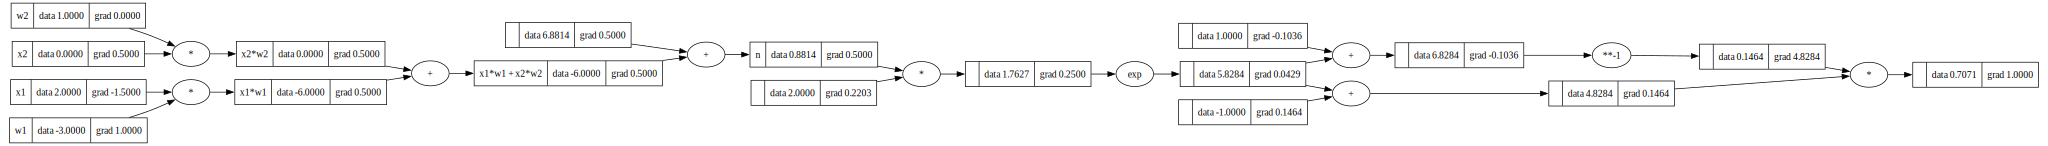

In [7]:
# inputs x1,x2
x1 = Value(2.0); x1.set_label("x1")
x2 = Value(0.0);x2.set_label("x2")
# weights w1,w2
w1 = Value(-3.0);w1.set_label("w1")
w2 = Value(1.0);w2.set_label("w2")
# bias of the neuron
b = Value(6.8813735870195432)
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = tanh(n)

o.backprop()
draw_dot(o)

In [8]:
import enum

class ActivationFunction(enum.Enum):
    TANH = "tanh"
    RELU = "relu"
    SIGMOID = "sigmoid"

def tanh(x: Value) -> Value:
    e = (2*x).exp()
    output = (e - 1) / (e + 1)

    return output

def relu(x: Value) -> Value:
    data = x.data
    output = Value(max(0, data), (x, ), 'relu')
    
    def _backward():
        x.grad += int(data > 0)
        
    output.backward = _backward
    return output

def sigmoid(x: Value) -> Value:
    output = 1 / (1 + (-x).exp())

    return output

def softmax(x: Value) -> Value:
    pass


activation_functions = {
    ActivationFunction.TANH: tanh,
    ActivationFunction.RELU: relu,
    ActivationFunction.SIGMOID: sigmoid,
}


In [9]:

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.act_func = act_func=ActivationFunction.TANH

    def __call__(self, x):
        # w * x + b
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        output = activation_functions[self.act_func](act)
        return output
      
    def parameters(self):
        return self.w + [self.b]

    def change_act_func(act_func):
        self.act_func = act_func

class Layer:
    def __init__(self, nin, nout, act_func=ActivationFunction.TANH):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.act_func = act_func
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def change_act_func(act_func):
        for neuron in self.neurons:
            neuron.change_act_func(self.act_func)


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
a = m(x)
a.backprop()
a
        

Value(0.011026167743557377)

In [10]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [11]:
for k in range(20):
  
    ypred = [m(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in m.parameters():
        p.set_grad(0.0)
    
    loss.backprop()
    
    for p in m.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)
  

0 5.883598183722805
1 3.493347962130751
2 2.521171032306824
3 1.9437137670705398
4 2.451530115220181
5 3.3914812288143357
6 1.2427262799758114
7 0.21132472332769622
8 0.09883887991560862
9 0.0716481257979803
10 0.058250917176543675
11 0.04988720116851554
12 0.04396932866716886
13 0.03945660154202543
14 0.035846670027753956
15 0.03286418253512273
16 0.030343148433321778
17 0.028175879091325854
18 0.026288382175956203
19 0.024627468500911055


In [12]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.sigmoid(n)
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071067435836176
---
x2 0.20710679676218968
w2 0.0
x1 -0.621320390286569
w1 0.41421359352437936


In [13]:
import tensorflow as tf

x1 = tf.Variable([2.0], dtype=tf.float64)
x2 = tf.Variable([0.0], dtype=tf.float64)
w1 = tf.Variable([-3.0], dtype=tf.float64)
w2 = tf.Variable([1.0], dtype=tf.float64)
b = tf.Variable([6.8813735870195432], dtype=tf.float64)

n = x1 * w1 + x2 * w2 + b

print(n.numpy().item())

with tf.GradientTape() as tape:
    n = x1 * w1 + x2 * w2 + b

grads = tape.gradient(n, [x1, x2, w1, w2, b])

print('---')
print('x2', grads[1].numpy().item())
print('w2', grads[3].numpy().item())
print('x1', grads[0].numpy().item())
print('w1', grads[2].numpy().item())


2024-07-19 13:37:32.903357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 13:37:33.063260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 13:37:33.064245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 13:37:33.316533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 13:37:34.585887: W tensorflow/compiler/tf

0.8813735870195432
---
x2 1.0
w2 0.0
x1 -3.0
w1 2.0


2024-07-19 13:37:35.487595: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
